In [62]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io

# from kinect_smoothing_test import HoleFilling_Filter, Denoising_Filter

In [63]:
mat = scipy.io.loadmat('cali/calibrationSession_ir.mat')
rgb_img = cv2.imread('test_img/output.jpg')
depth_img = cv2.imread('test_img/depth_4040.png',cv2.IMREAD_UNCHANGED)

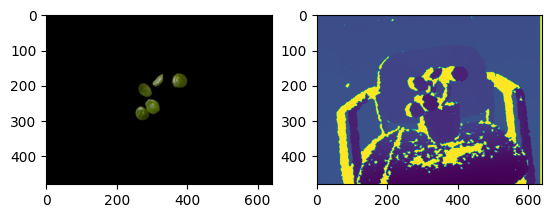

In [64]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(rgb_img[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(depth_img)

In [4]:
class camera():
    def __init__(self):
        self.ir_intrinsic_matrix = np.array(
            [[584.841889585306, 0, 334.223973735139],
             [0, 585.098792372885, 238.286484000484], [0, 0, 1]])
        self.ir_distortion_matrix = np.array(
            [-0.0838026334631467, 0.215827239774552, 0, 0, 0])
        self.rgb_intrinsic_matrix = np.array(
            [[524.809302793968, 0, 318.735329475219],
             [0, 525.619941290883, 257.725291615261], [0, 0, 1]])
        self.rgb_distortion_matrix = np.array(
            [0.147555317189259, -0.303342952312001, 0, 0, 0])

        self.A = np.array([[0.9999, -0.0049, 0.0112, -20/1000],
                           [0.0049, 1.0000, -0.0025, -1.3/1000],
                           [-0.0112, 0.0026, 0.9999, 5.9/1000]])

        self.imgsz = (640, 480)
        return

    def rectify(self):

        return

    def undistortion(self, distorted_img, camera_type):
        # Correcting the distortion
        if camera_type == 'rgb':
            camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
                self.rgb_intrinsic_matrix, self.rgb_distortion_matrix,
                self.imgsz, 1, self.imgsz)
            undistorted_img = cv2.undistort(
                distorted_img, self.rgb_intrinsic_matrix,
                self.rgb_distortion_matrix, None,
                camera_matrix)  # Correcting the distortion
        elif camera_type == 'ir':
            camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
                self.ir_intrinsic_matrix, self.ir_distortion_matrix,
                self.imgsz, 1, self.imgsz)
            undistorted_img = cv2.undistort(
                distorted_img, self.ir_intrinsic_matrix,
                self.ir_distortion_matrix, None,
                camera_matrix)  # Correcting the distortion
        return undistorted_img, camera_matrix

In [5]:
kinect = camera()

In [6]:
dist = 0.1236*2 * np.tan(depth_img / 2842.5 + 1.1863)-0.033
# epsilon = 1e-5  # A small constant to avoid division by zero
# dist = 0.075 * 580 / (1090 -depth_img + epsilon) * 8*1000
# dist = 1/(depth_img*(-0.0030711016)+3.3309495161)

dist[dist<0.2] = -1
dist[dist>2.1] = -1
depth_img.shape

(480, 640)

In [7]:
np.max(dist[~np.isnan(dist)])

1.9764606066774042

In [8]:
# w = 640
# h = 480
rgb_img, mtx_rgb = kinect.undistortion(rgb_img,'rgb')
depth_img, mtx_ir = kinect.undistortion(depth_img,'ir')
mtx_rgb = kinect.rgb_intrinsic_matrix
mtx_ir = kinect.ir_intrinsic_matrix

In [9]:
depth_img.shape

(480, 640)

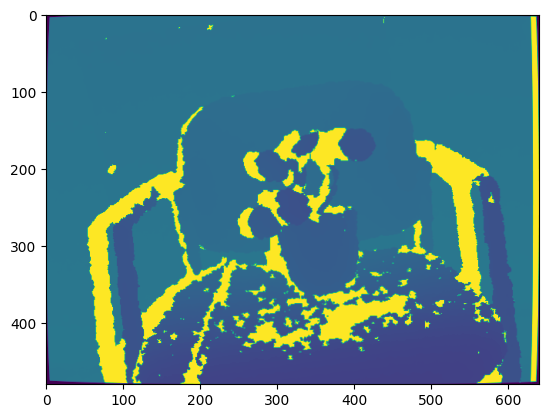

In [10]:
plt.imshow(depth_img)

In [11]:
def pixel2world(x,y,intrinsic_matrix, dist):
    cx = intrinsic_matrix[0,2]
    cy = intrinsic_matrix[1,2]
    fx = intrinsic_matrix[0,0]
    fy = intrinsic_matrix[1,1]
    Z = dist[y, x]
    X = (x - cx) * Z / fx
    Y = (y - cy) * Z / fy
    return X, Y ,Z
    

In [12]:
x = np.tile(np.arange(640), (480, 1))
y = np.tile(np.arange(480).reshape(-1, 1), (1, 640))
X,Y,Z = pixel2world(x,y,mtx_ir, dist)
# Flatten the matrices
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Combine into a single array of 3D points
points_3d = np.vstack((X_flat, Y_flat, Z_flat)).T
# Remove rows where Z < 0
points_3d = points_3d[points_3d[:, 2] >= 0]

In [13]:
import open3d as o3d
import numpy as np
FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
# Let's say 'points_3d' is your array of 3D points (numpy array)
# points_3d.shape should be (N, 3), where N is the number of points

# Create an Open3D point cloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Visualize the point cloud
# o3d.visualization.draw_geometries([pcd,FOR1])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:
points_3d = np.append(points_3d.T, np.ones((1,points_3d.shape[0])),axis=0).T

In [15]:
E = kinect.A
K = mtx_rgb
T_ir2rgb = K.dot(E)
raw_pixel = T_ir2rgb.dot(points_3d.T).T



In [16]:
rgb_pixel = (raw_pixel/(raw_pixel[:,-1]).reshape(-1,1)).astype(int)

In [17]:
rgb_pixel

array([[371, 118,   1],
       [372, 118,   1],
       [373, 118,   1],
       ...,
       [565, 473,   1],
       [566, 473,   1],
       [567, 473,   1]])

<Axes: ylabel='Frequency'>

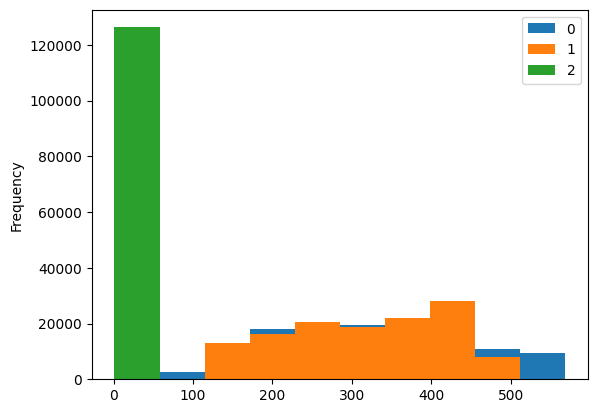

In [18]:
df_rgb_pixel = pd.DataFrame(rgb_pixel)
df_rgb_pixel.plot.hist()

In [19]:
h = points_3d.shape[0]
points_3d_color  = np.zeros((h,3))
for i,v in enumerate(points_3d):
    u,v = rgb_pixel[i][:2]
    if u>=640 or v>=480:
        pc =  np.array([np.nan,np.nan,np.nan])
    elif  u<0 or v<0:
        pc = np.array([np.nan,np.nan,np.nan])
    else:
        pc = rgb_img[v,u]
    points_3d_color[i] = pc
    

In [20]:
# Creating a point cloud object
pcd = o3d.geometry.PointCloud()

# points_3d[:,0] = points_3d[:,0]
# Assigning the points
pcd.points = o3d.utility.Vector3dVector(points_3d[:, :3])

# Assigning the colors
pcd.colors = o3d.utility.Vector3dVector(points_3d_color[:,[2, 1, 0]]/ 255.0)
# FOR1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=200, origin=[0, 0, 0])

# Visualizing the point cloud
o3d.visualization.draw_geometries([pcd,FOR1])

In [21]:
downpcd = pcd.uniform_down_sample(every_k_points = 5)
# Visualizing the point cloud
o3d.visualization.draw_geometries([downpcd,FOR1])

In [22]:
plane_model, inliers = downpcd.segment_plane(distance_threshold=0.08,
                                         ransac_n=100,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downpcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downpcd.select_by_index(inliers, invert=True)
outlier_cloud.paint_uniform_color([0, 1, 0])
o3d.visualization.draw_geometries([outlier_cloud])

Plane equation: 0.07x + 0.90y + 0.43z + -0.77 = 0


In [23]:
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        outlier_cloud.cluster_dbscan(eps=0.05, min_points=50, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
outlier_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([outlier_cloud])


[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 14
point cloud has 14 clusters


In [24]:
np.asarray(outlier_cloud.points)
np.asarray(outlier_cloud.colors)


array([[0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       [0.12156863, 0.46666667, 0.70588235],
       ...,
       [0.09019608, 0.74509804, 0.81176471],
       [0.09019608, 0.74509804, 0.81176471],
       [0.09019608, 0.74509804, 0.81176471]])

In [25]:
# Remove radius outliers
cleaned_cloud = outlier_cloud.remove_radius_outlier(nb_points=20, radius=0.035)
cleaned_cloud = cleaned_cloud[0].random_down_sample(0.96)
o3d.visualization.draw_geometries([cleaned_cloud])


In [ ]:
from pymeshfix import MeshFix

In [30]:
import open3d as o3d

# Create a mesh from the point cloud using alpha shape
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(cleaned_cloud, alpha=0.01)

# Save the mesh as a PLY file
o3d.io.write_triangle_mesh("point_cloud.ply", mesh)
import open3d as o3d

# 假设您的点云已经存储在变量 cloud 中，类型为 Open3D 的 PointCloud 对象

# 将点云转换为三角网格

# 计算三角网格的表面积
surface_area = mesh.compute_triangle_normals().get_surface_area()

print("点云的表面积为:", surface_area)

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh

In [31]:
import open3d as o3d

# Assuming cleaned_cloud is your point cloud
# Compute normal vectors for the point cloud
cleaned_cloud.estimate_normals()

# Perform Poisson surface reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    cleaned_cloud, depth=12)

In [32]:
# Visualize the reconstructed mesh
o3d.visualization.draw_geometries([mesh])

C:\Users\26851\anaconda3\envs\img_process\Lib\site-packages\pymeshfix\examples\planar_mesh.ply


C:\Users\26851\anaconda3\envs\img_process\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\26851\anaconda3\envs\img_process\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


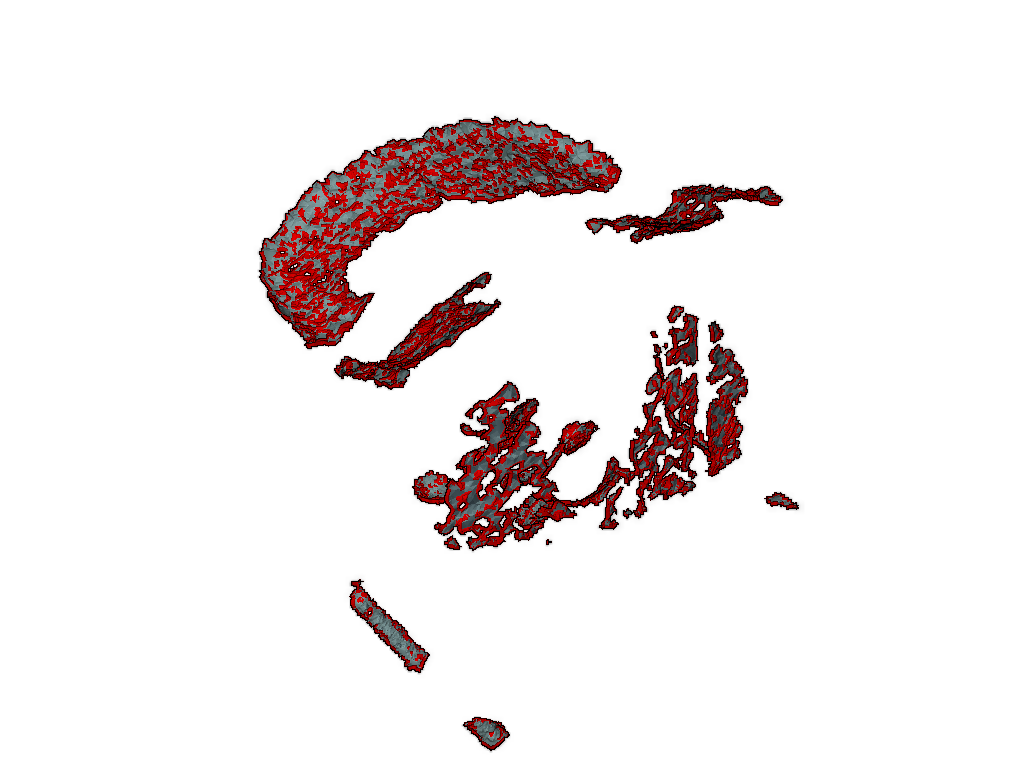

C:\Users\26851\anaconda3\envs\img_process\lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\26851\anaconda3\envs\img_process\lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


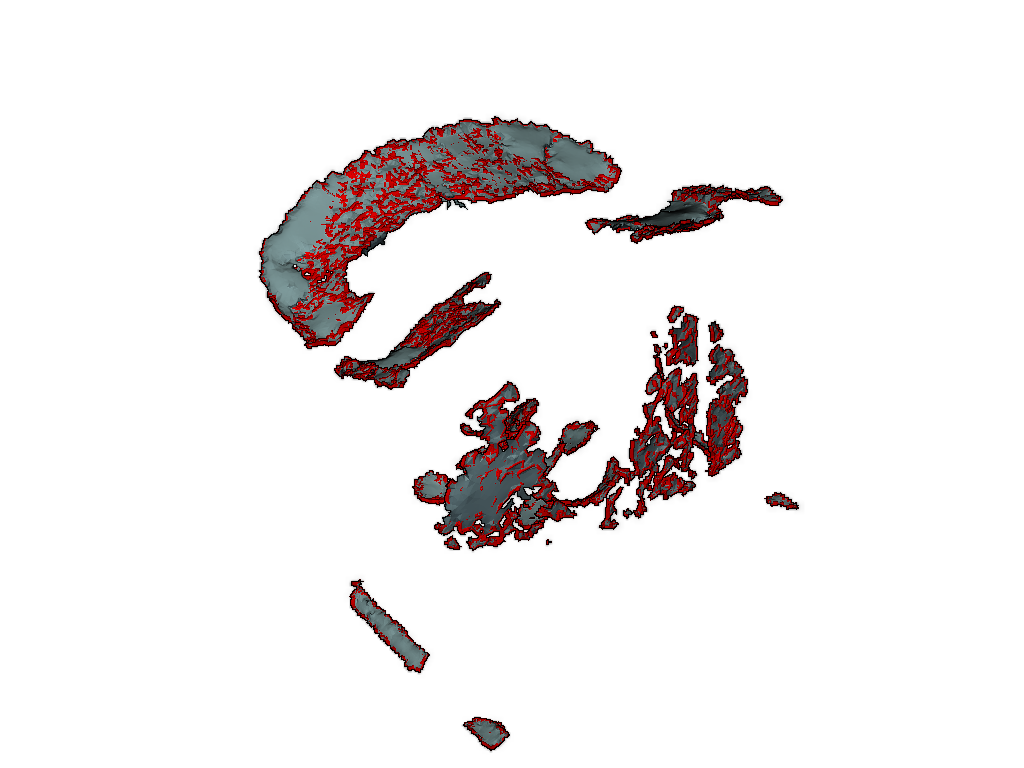

In [33]:
# sphinx_gallery_thumbnail_number = 1
import numpy as np
from pymeshfix import MeshFix
from pymeshfix._meshfix import PyTMesh
from pymeshfix.examples import planar_mesh
import pyvista as pv
import trame
import vtk

##########################  加载mesh并展示其空洞 #######################################
#读取mesh
print(planar_mesh)
planar_mesh="cat_hole.ply"
orig_mesh = pv.read(planar_mesh)
#orig_mesh = pv.read("hole.obj")
# orig_mesh.plot_boundaries()

#计算mesh的孔洞
meshfix = MeshFix(orig_mesh)
holes = meshfix.extract_holes()

#将mesh与孔洞进行叠加展示
plotter = pv.Plotter()
plotter.add_mesh(orig_mesh, color=True)
plotter.add_mesh(holes, color="r", line_width=5)
plotter.enable_eye_dome_lighting()  # helps depth perception
_ = plotter.show()


############################  mesh空洞修复   ####################################
#构建PyTMesh修复对象mfix，并加载要修复的mesh
mfix = PyTMesh(True)  
mfix.load_file(planar_mesh)
#mfix = MeshFix(orig_mesh)
#填充最多具有“nbe”边界边缘的所有孔,如果“refine”为true，添加内部顶点以重现采样周围环境的密度。返回修补的孔数。
#“nbe”为0（默认值），则修复所有孔，值越大则表明
mfix.fill_small_boundaries(nbe=0, refine=True)

############################  将PyTMesh对象转换为pyvista mesh #########################################
#
vert, faces = mfix.return_arrays()
triangles = np.empty((faces.shape[0], 4), dtype=faces.dtype)
triangles[:, -3:] = faces
triangles[:, 0] = 3
mesh = pv.PolyData(vert, triangles)

############################ 进行可视化，并保存mesh #########################################

plotter = pv.Plotter()
plotter.add_mesh(mesh, color=True)
plotter.add_mesh(holes, color="r", line_width=5)
plotter.enable_eye_dome_lighting()  # helps depth perception
_ = plotter.show()

mesh.save(planar_mesh.replace(".ply","_r.ply"))


In [ ]:
import trimesh

In [34]:
import open3d as o3d

# 假设您的 PLY 文件路径为 "point_cloud.ply"
ply_file = "cat_hole_r.ply"

# 读取 PLY 文件
cleaned_cloud = o3d.io.read_point_cloud(ply_file)

# 可视化点云
o3d.visualization.draw_geometries([cleaned_cloud])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [37]:
import pymeshfix

# Create TMesh object
tin = pymeshfix.PyTMesh()

pv.read('cat_hole.ply')
# tin.load_array(v, f) # or read arrays from memory

# Attempt to join nearby components
# tin.join_closest_components()

# Fill holes
tin.remove_smallest_components()
print('There are {:d} boundaries'.format(tin.boundaries()))

# Clean (removes self intersections)
tin.clean(max_iters=10, inner_loops=10)

# Check mesh for holes again
print('There are {:d} boundaries'.format(tin.boundaries()))

# Clean again if necessary...

# # Output mesh
# tin.save_file(outfile)

 # or return numpy arrays
vclean, fclean = tin.return_arrays()

There are 0 boundaries
There are 0 boundaries


In [39]:
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd)

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    pcd, 0.015, tetra_mesh, pt_map)
mesh.compute_vertex_normals()

o3d.visualization.draw_geometries([mesh])

[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh

In [ ]:
o3d.visualization.draw_geometries([filled_mesh])

In [44]:
# Create a mesh from the point cloud using alpha shape
# mesh= o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha=0.1)

# Assuming `mesh` is your triangle mesh loaded as an Open3D TriangleMesh object
# Convert Open3D TriangleMesh to Trimesh object
trimesh_mesh = trimesh.Trimesh(vertices=mesh.vertices, faces=mesh.triangles)

# Fill holes in the mesh
trimesh_filled = trimesh_mesh.fill_holes()

# Convert Trimesh object back to Open3D TriangleMesh object
o3d_filled = o3d.geometry.TriangleMesh()
o3d_filled.vertices = o3d.utility.Vector3dVector(trimesh_filled.vertices)
o3d_filled.triangles = o3d.utility.Vector3iVector(trimesh_filled.faces)

# Visualize the filled mesh
o3d.visualization.draw_geometries([o3d_filled])

AttributeError: 'bool' object has no attribute 'vertices'

In [42]:
import trimesh

In [ ]:
np.logspace(np.log10(0.6), np.log10(0.01), num=10)

In [ ]:
mesh.vertices

In [ ]:
mesh

In [ ]:
trimesh_filled

NameError: name 'trimesh' is not defined